In [1]:
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np


In [3]:

class VGGNet(nn.Module):
    def __init__(self, features, num_classes):
        super().__init__()
        
        self.features = features
        
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [4]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

In [5]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 1
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

In [6]:
vfeat = get_vgg_layers(vgg11_config,True)

In [7]:
from google.colab import files,drive
drive.mount('/content/drive')

def vggnet( pretrained=False,**kwargs):
    model = VGGNet(**kwargs)
    model.to('cuda:0')

    if(pretrained):
      model.load_state_dict(torch.load('./drive/MyDrive/NN/VGGNet.pt'))
    return model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:

img_size = 256
t_tf = transforms.Compose([transforms.Resize((img_size ,img_size )),transforms.ToTensor()])
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=t_tf,

)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=t_tf,
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


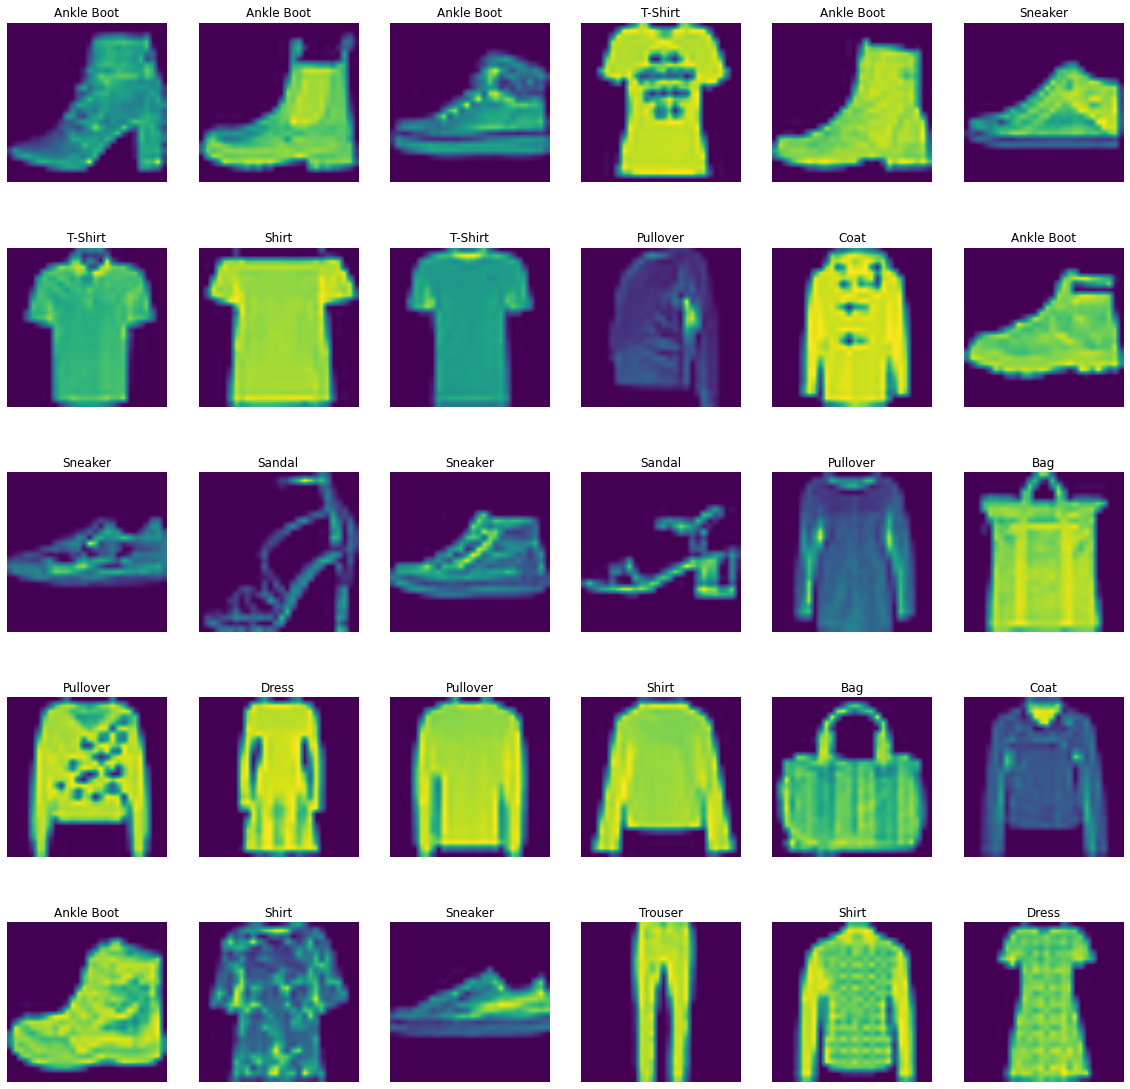

In [9]:
random_id = np.random.randint(len(training_data),size=(30))
plt.figure(figsize=(20,20))
plt.title('Dataset Sample')
for i,id in enumerate(random_id):
  plt.subplot(5,6,i+1)
  image = training_data[id][0].squeeze()
  label = labels_map[training_data[id][1]]
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

In [24]:

ds = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=t_tf,
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),
)
trainloader = torch.utils.data.DataLoader(ds, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last=False, pin_memory=True,persistent_workers=True)

tds = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=t_tf,
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)
testloader = torch.utils.data.DataLoader(tds,
                                          shuffle=True, num_workers=2,batch_size=64)

In [11]:

mynet = vggnet(features=vfeat,num_classes=10)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mynet.parameters(),lr=0.01,momentum=0.45)

In [15]:
running_loss = 0
e_loops = 40

mynet.train()

losses = []
accuracies = []
running_accr = 0
for epoch in range(20):
  running_loss = 0.0
  running_accr = 0.0
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    inputs = inputs.to('cuda:0')
    labels = labels.to('cuda:0')
    
    optimizer.zero_grad()

    outputs = mynet(inputs)
    ly = torch.argmax(labels,axis=1)
    lo = torch.argmax(outputs,axis=1)
    loss = criterion(outputs,ly)
    accr = (ly == lo).sum().detach().item()
    running_accr += accr
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.detach().item()
    if i % e_loops == e_loops-1:    # print every 2000 mini-batches
        running_loss /= e_loops
        running_accr /= e_loops * (64)
        print('[%d, %5d] loss: %.3f - accuracy %.3f' %
              (epoch + 1, i + 1, running_loss ,running_accr))
        losses.append(running_loss)
        accuracies.append(running_accr)
        running_loss = 0.0
        running_accr = 0.0
  torch.save(mynet.state_dict(), "./drive/MyDrive/NN/VGGNet.pt")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    40] loss: 1.396 - accuracy 0.493
[1,    80] loss: 0.770 - accuracy 0.709
[1,   120] loss: 0.591 - accuracy 0.773
[1,   160] loss: 0.596 - accuracy 0.770
[1,   200] loss: 0.542 - accuracy 0.796
[1,   240] loss: 0.529 - accuracy 0.806
[1,   280] loss: 0.522 - accuracy 0.803
[1,   320] loss: 0.484 - accuracy 0.823
[1,   360] loss: 0.440 - accuracy 0.841
[1,   400] loss: 0.417 - accuracy 0.839
[1,   440] loss: 0.408 - accuracy 0.848
[1,   480] loss: 0.414 - accuracy 0.840
[1,   520] loss: 0.417 - accuracy 0.847
[1,   560] loss: 0.378 - accuracy 0.856
[1,   600] loss: 0.392 - accuracy 0.857
[1,   640] loss: 0.367 - accuracy 0.866
[1,   680] loss: 0.372 - accuracy 0.861
[1,   720] loss: 0.347 - accuracy 0.870
[1,   760] loss: 0.355 - accuracy 0.875
[1,   800] loss: 0.354 - accuracy 0.870
[1,   840] loss: 0.318 - accuracy 0.884
[1,   880] loss: 0.351 - accuracy 0.873
[1,   920] loss: 0.339 - accuracy 0.874
[2,    40] loss: 0.323 - accuracy 0.876
[2,    80] loss: 0.330 - accuracy 0.883


KeyboardInterrupt: ignored

In [16]:
torch.save(mynet.state_dict(), "./drive/MyDrive/NN/VGGNet.pt")

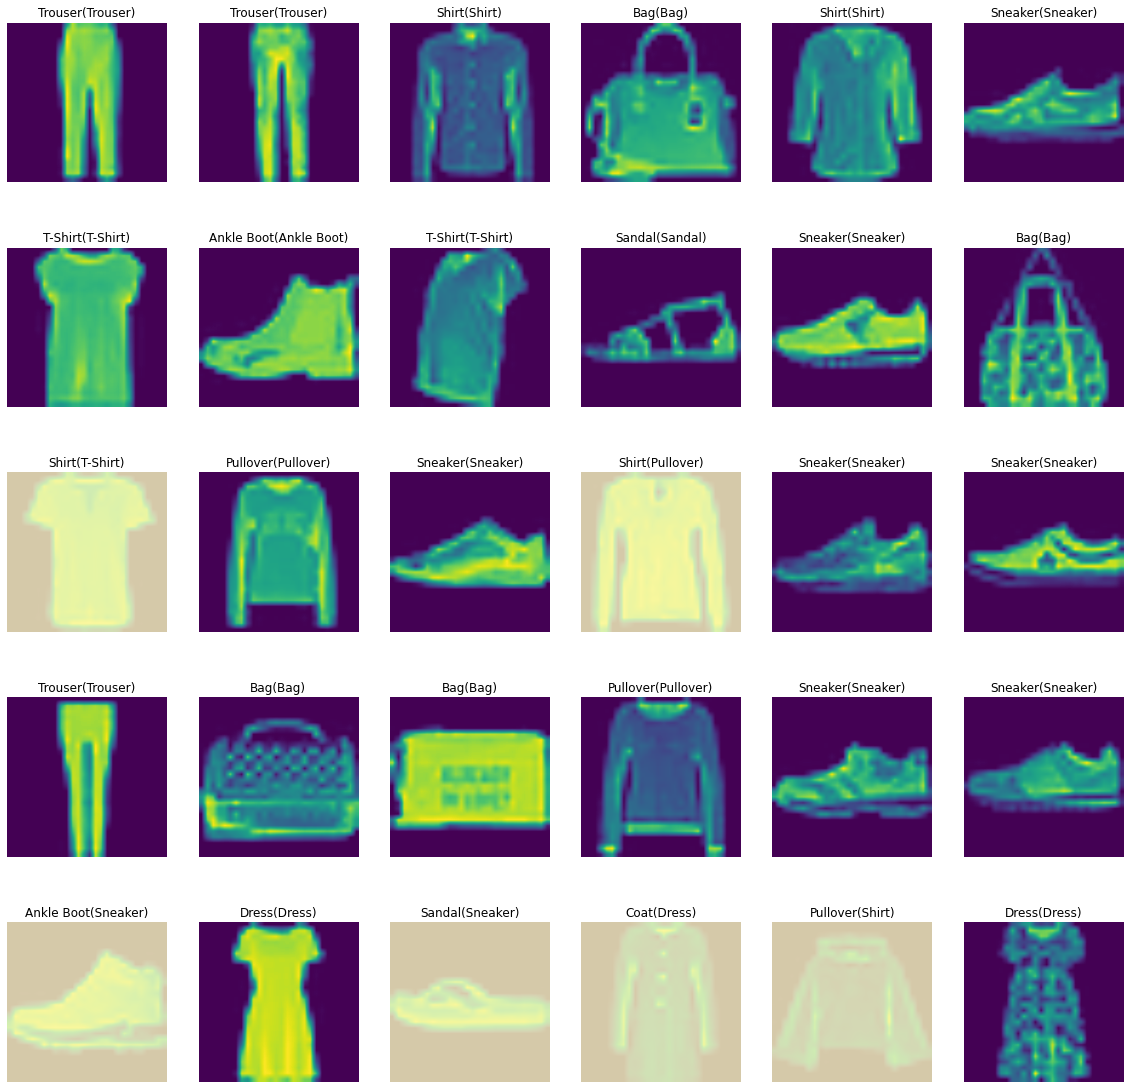

In [17]:
mynet.eval()
random_id = np.random.randint(len(test_data),size=(30))
plt.figure(figsize=(20,20),facecolor='white')
for i,id in enumerate(random_id):
  plt.subplot(5,6,i+1)
  image = test_data[id][0].squeeze()
  olabel = np.argmax(mynet(image.unsqueeze(0).unsqueeze(0).to('cuda:0')).detach().cpu().numpy())
  olabel = labels_map[olabel]
  
  
 
  label = labels_map[test_data[id][1]] + f"({olabel})"
  plt.title(label)
  plt.axis('off')
  plt.imshow(image)

  if(olabel != labels_map[test_data[id][1]] ):
    plt.imshow(np.ones(shape=image.shape),alpha=0.8,cmap='magma_r')
  

In [18]:
def measureAccuracy():
  total = 0
  correct = 0
  with torch.no_grad():
      mynet.eval()
      for data in testloader:

          inputs,labels = data
          inputs = inputs.to('cuda:0')
          labels = labels.to('cuda:0')
          outputs = mynet(inputs)
          _, predicted = torch.max(outputs.data, 1)
          _, expected = torch.max(labels,1)
          total += labels.size(0)
        
          correct += (predicted == expected).sum().detach().item()

  return  correct / total

In [19]:
e_accr = []

for i in range(len(accuracies)//11):
  sub =accuracies[(i*11):(i*11+11)]
  e_accr.append(sum(sub) / len(sub))

In [20]:
e_loss = []

for i in range(len(losses)//11):
  sub =losses[(i*11):(i*11+11)]
  e_loss.append(sum(sub) / len(sub))

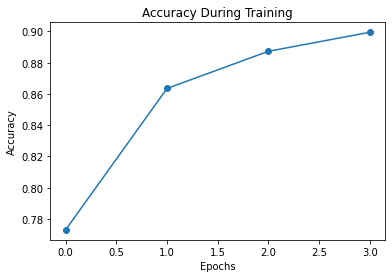

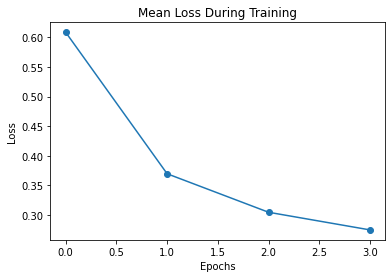

In [21]:
plt.title('Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(e_accr,marker='o')
plt.show()
plt.title('Mean Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(e_loss,marker='o')

In [27]:
print(f"Accuracy On Test Data : {measureAccuracy()}")

Accuracy On Test Data : 0.9023
